本章包括以下内容：
* 将文本数据预处理为有用的数据表示
* 使用循环神经网络RNN
* 使用一维卷积神经网络处理序列

本章将介绍使用深度学习模型处理文本（可以将其理解为单词序列或字符序列）、时间序列和一般的序列数据。用于处理序列的两种基本的深度学习算法分别是**循环神经网络(RNN，recurrent neural network)**和**一维卷积神经网络(1D convnet)**，后一章是上一节介绍的二维卷积神经网络的一维版本。本章将讨论这两种方法。  
这些算法的应用包括：
* 文档分类和时间序列分类，比如识别文章的主题或书的作者
* 时间序列对比，比如预估两个文档或两只股票行情的相关程度
* 序列到序列的学习，比如将英语翻译成法语
* 情感分析，比如将推文或电影的评论的感情划分为正面或负面
* 事件序列预测，比如根据某地最近的天气数据来预测未来天气

本章的示例重点讨论两个小任务：一个是IMDB数据集的情感分析，这个任务前面介绍过；另一个是温度预测，但这两个任务中所使用的技术都可以用于上面列出来的所有应用。

## 6.1 处理文本数据
本章的这些深度学习模型并没有像人类一样真正理解文本，而只是映射出书面语言的统计结构，但这足以解决许多简单文本任务 
和其他神经网络一样，深度学习模型不会接收原始文本作为输入，他只能处理数值张量，文本**向量化(vectorize)**是指将文本转换为数值张量的过程
* 将文本分割成单词，每一个单词转换为一个向量
* 将文本分割成字符，每一个字符转换为一个向量
* 提取单词或字符的n-gram，并将每个n-gram转换为一个向量。n-gram是多个连续单词或字符的集合(n-gram之间可以重复)

将文本分解而成的单元叫做**标记(token)**，将文本分解成标记的过程叫做**分词(tokenization)**。  
word_frequencies是一个字典，记录单词和对应的频率，再将字典按照频率从高到低进行排序，之后将频率frequency替换成索引index，就得到了word_index字典，按照频率从高到低记录了对应的单词和索引。
所有文本向量化过程都是应用某种分词方案，然后将数值向量和生成的标记相关联。这些向量组合成的序列张量，被输入到深度神经网络中。  
向量和标记相关联的方法：    
* 对标记做one-hot编码(one-hot encoding)
* 标记嵌入(token embedding)
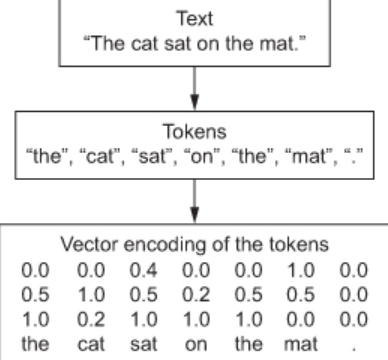

### 6.1.1 单词和字符的one-hot编码
one-hot编码是将标记变成向量的最常用最基本的方式。前面第三章的IMBD和路透社例子中（我们使用的是单词）我们已经应用过它。它包括将每个单词编码成一个唯一的整数序号，然后将这个整数序号i转换成一个N大小的二元向量，N是单词表的大小，也就是除了第i项为1外，向量的其他元素都为0。

当然，one-hot编码也可以用在字符层面。下面我们用两个玩具代码例子来详细说明one-hot编码概念以及如何实现，一个针对单词，另一个针对字符：

In [1]:
#1、单词级的one-hot编码
import numpy as np

samples = ["The cat on the sat", "The dog ate my homework"]  #初始化数据

token_index = {}                #构建数据中所有单词和索引的字典
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1 #为每一个单词制定一个唯一的索引
            
max_length = 10                #只考虑样本的前max_length个单词
results = np.zeros(shape = (len(samples), 
                            max_length, 
                            max(token_index.values()) + 1)) #存储one-hot编码的结果

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1

In [2]:
results.shape

(2, 10, 10)

### 字符级的one-hot编码

In [3]:
import string

samples = ["The cat on the sat", "The dog ate my homework"]  #初始化数据
characters = string.printable
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros(shape = (len(samples),
                            max_length, 
                            max(token_index.values()) + 1))

for i, sample in enumerate(samples):
    for j, charater in enumerate(sample[:max_length]):
        index = token_index.get(charater)
        results[i, j, index] = 1

In [4]:
results.shape

(2, 50, 101)

In [6]:
print(characters)
print(token_index)
print(results)

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

{'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, 'a': 11, 'b': 12, 'c': 13, 'd': 14, 'e': 15, 'f': 16, 'g': 17, 'h': 18, 'i': 19, 'j': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 'o': 25, 'p': 26, 'q': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'w': 33, 'x': 34, 'y': 35, 'z': 36, 'A': 37, 'B': 38, 'C': 39, 'D': 40, 'E': 41, 'F': 42, 'G': 43, 'H': 44, 'I': 45, 'J': 46, 'K': 47, 'L': 48, 'M': 49, 'N': 50, 'O': 51, 'P': 52, 'Q': 53, 'R': 54, 'S': 55, 'T': 56, 'U': 57, 'V': 58, 'W': 59, 'X': 60, 'Y': 61, 'Z': 62, '!': 63, '"': 64, '#': 65, '$': 66, '%': 67, '&': 68, "'": 69, '(': 70, ')': 71, '*': 72, '+': 73, ',': 74, '-': 75, '.': 76, '/': 77, ':': 78, ';': 79, '<': 80, '=': 81, '>': 82, '?': 83, '@': 84, '[': 85, '\\': 86, ']': 87, '^': 88, '_': 89, '`': 90, '{': 91, '|': 92, '}': 93, '~': 94, ' ': 95, '\t': 96, '\n': 97, '\r': 98, '\x0b': 99, '\x0c': 10

### 用Keras实现单词级one-hot编码

In [5]:
from keras.preprocessing.text import Tokenizer

samples = ["The cat on the sat", "The dog ate my homework"]

tokenizer = Tokenizer(num_words = 1000) #创建一个分词器，只考虑前1000个最常见的单词
tokenizer.fit_on_texts(samples)         #构建单词索引

sequences = tokenizer.texts_to_sequences(samples) #将字符串转换成整数索引组成的列表

one_hot_results = tokenizer.texts_to_matrix(samples, mode = 'binary') #得到one-hot的二进制表示

word_index = tokenizer.word_index #找回单词索引
print('Found %s unique tokens.' % len(word_index))

Found 8 unique tokens.


## 6.1.2 使用词嵌入\
另一种流行又强大的将单词和一个向量联系起来的方法是使用密集的“**词向量**”，也被称为“词嵌入”。相比one-hot编码获得的二元的、稀疏的（大部分为0）和非常高维的（与单词表中的不同单词的数量一样维度值）的张量不同，“词嵌入”使用的是低维度的浮点数向量（也就是密集的向量，相对稀疏向量而言）。不像one-hot编码获得的词向量，词嵌入获得的向量是从数据中学习获得的。在处理非常大的词汇表时通常使用的词嵌入是256维、512维或1024维的。与此同时，使用one-hot编码将会获得20000个维度或以上（整个词汇表含有20000个不同的单词）。因此词嵌入在极小的空间维度中封装了更多的信息。

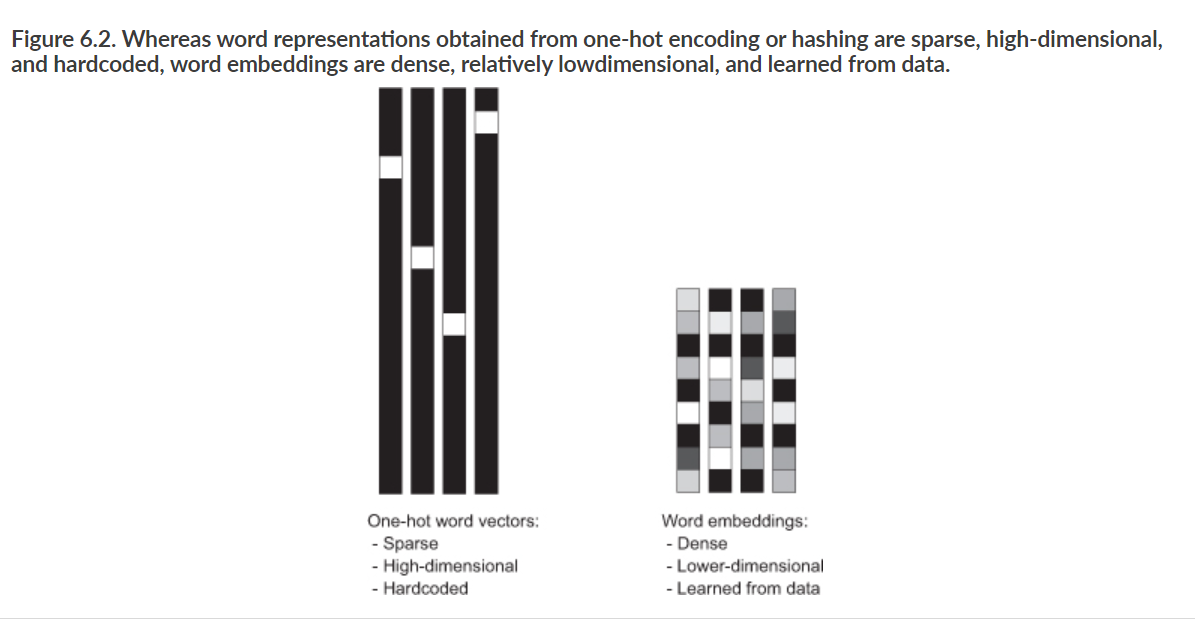

图6-2 one-hot编码和词嵌入对比
 
获取词嵌入有两种方法：  
* 在完成主任务的同时学习词嵌入。在这种情况下一开始是随机的词向量，然后对这些词向量进行学习，其学习的方式与学习神经的权值相同。
* 在不同于待解决问题的机器学习任务上预计算好词嵌入，然后将其加载到模型中。这些词嵌入叫做预训练词嵌入

In [6]:
#将一个Embedding层实例化
from keras.layers import Embedding

embedding_layer = Embedding(1000, 64)   #Embedding层至少需要两个参数：标记的个数和嵌入的维度

#加载IMDB数据集用于Embedding层
from keras.datasets import imdb
from keras import preprocessing

max_feature = 10000     #作为特征的单词个数
max_len = 20            #在这么多单词后截断文本

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_feature)  #加载数据为整数列表

#将整数列表转换为形状为(samples, maxlen)的二维整数张量，proprecessing预处理数据，pad_sequences填充序列，让序列的长度相等
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen = max_len)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen = max_len)
#x_train.shape = (25000, 20)是一个2D张量，可以输入到Embdding层中

Embedding层的输入是一个二维整数张量，其形状为(samples, sequences_length)，每一个元素是一个整数序列。  
返回的是一个形状为(samples, sequences_length, embedding_dimensionality)的三维浮点数张量，然后可以用RNN层或一维卷积来处理这个三维张量。  
将一个Embedding层实例化时，它的权重（即标记向量的内部字典）最开始是随机的，与其它层一样。  
在训练过程中通过反向传播来逐渐调节这些词向量，改变空间结构以便下游模型可以利用。  
一旦训练完成，嵌入空间将会展示大量结构，这种结构专门针对训练模型所要解决的问题。

### 在IMDB数据集上使用Embedding层和分类器

In [7]:
#加载IMDB数据集用于Embedding层
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

max_feature = 10000     #作为特征的单词个数
max_len = 20            #在这么多单词后截断文本

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_feature)  #加载数据为整数列表

#将整数列表转换为形状为(samples, maxlen)的二维整数张量，proprecessing预处理数据，pad_sequences填充序列，让序列的长度相等
x_train = pad_sequences(x_train, maxlen = max_len)
x_test = pad_sequences(x_test, maxlen = max_len)
#x_train.shape = (25000, 20)是一个2D张量，可以输入到Embdding层中

最好将Embedding层理解为一个字典，将整数索引（表示特定单词）映射为密集向量。它接受整数作为输入，并在内部字典中查找这些整数，然后返回相关的向量。Embedding层实际上是一种字典查找
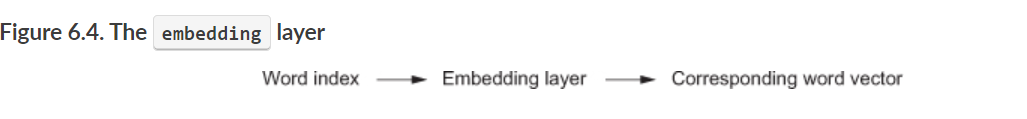

嵌入层接收一个二维的整数张量作为输入，形状是(samples, sequence_length)，其中每个元素都是一个整数的序列。它可以嵌入长度可变的序列，因此我们可以往嵌入层输入形状为(32, 10)（批次32个序列，每个序列长度为10）或者(64, 15)（批次64个序列，每个序列长度为15）的张量。一个批次中所有的序列长度必须相同（因为我们需要将它们封装到一个张量当中），因此那些长度不足的序列需要在后面的维度上补0，那些超过长度的序列将会被截断。

Emebedding返回一个三维的浮点数张量，形状为(sampels, sequences, embedding_dimenionality)。这样输出的三维张量后续可以被一个RNN层或者一个一维卷积层接收（将会在下一小节介绍）。

当你初始化一个Embedding层时，它的权重值（其内部字典中的标记向量）是随机产生的，就像其他的层一样。在训练过程中，这些词向量也会通过反向传播进行更新，改变空间结构以便下游模型可以利用。一旦训练完成，嵌入空间会展示很多结构化信息，这些结构化信息能够很好的体现你的训练模型用来解决的实际问题。

In [8]:
network.summary()

#绘制网络模型
from tensorflow.keras.utils import plot_model
plot_model(network, show_shapes = True, to_file = 'imdb with word embedding.png')

history = network.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 1s 883us/step - loss: 0.6719 - accuracy: 0.6236 - val_loss: 0.6278 - val_accuracy: 0.6952
Epoch 2/10
625/625 [==============================] - 0s 705us/step - loss: 0.5500 - accuracy: 0.7509 - val_loss: 0.5325 - val_accuracy: 0.7294
Epoch 3/10
625/625 [========

我们获得了约76%的验证准确率（和随机猜得到的准确率50%相比，这说明在训练过程中模型学到了东西），考虑到我们仅仅使用了每条影评的头20个单词来说，这个结果还是很不错的。这里需要注意的是，直接将嵌入的序列铺平然后在其上放置一个全连接层的结构，会导致我们的模型会将输入中的每个单词独立处理，而不会考虑单词之间的关联和句子的结构（例如，模型可能会将“this movie is shit”表示“这部电影太烂了”，和“this movie is the shit”表示“这部电影太牛逼了”都预测为负面评论）。如果在嵌入序列之上再放置一个循环层或者1D卷积层的话，就能将整个句子或短语一起进行评价。这将会是后续几个小节的重点。

2. 使用预训练的词嵌入
让我们看一下在Keras模型中如何开始使用GloVe嵌入。当然这个方法对于Word2Vec嵌入和其他网上可下载词嵌入数据集都是通用的。我们还能用这个例子来复习一下前几个小节介绍的知识：我们使用原始文本开始，然后逐步搭建模型。

## 6.1.3 整合在一起：从原始文本到词嵌入
我们会使用和前面相似的模型，将一个句子嵌入成一个向量序列，然后将其铺平，最后用一个全连接层来训练。但下面我们会使用预训练的词嵌入，而不是使用Keras中封装号的预标记化的IMDB数据，我们会从零开始，首先是下载原始文本数据。

#### 1、下载IMDB原始文本数据

首先，前往[这里](https://ai.stanford.edu/~amaas/data/sentiment/)下载原始IMDB数据集（如果URL失效了，请谷歌“IMDB dataset”）。然后解压缩。

下面我们将每个训练影评封装成字符串的列表，每个评论一个字符串，然后我们也将评论的标签（正面/负面）也封装成一个标签列表：  

### 处理IMDB数据集的原始文本

In [9]:
import os

imdb_dir = 'D:\\Download\\aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['pos', 'neg']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding = 'utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
print("Legnth of training's texts", len(texts))
print("Length of training labels", len(labels))    
print(texts[0])
print(labels[0])

### 2、对数据进行分词
因为预训练词嵌入一般应用在较少训练数据的情况下（否则的话，依据任务特性需要训练的词嵌入方法一般都会表现更好），因此我们对数据集进行进一步裁剪：我们只采用训练数据的前200个样本。最终我们将会获得一个仅学习了200个影评样本数据的情绪预测模型......

In [10]:
#对IMDB原始数据集进行分词
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100                 #在100个词后截断评论
training_samples = 200       #在200个样本上进行训练
validation_samples = 10000   #在10000个样本上进行验证
max_words = 10000            #只考虑数据集中前10000个常见的单词

tokenizer = Tokenizer(num_words=max_words)        #创建一个分词器只考虑前10000个常见的单词
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)   #将文本转换成数字序列
print('Length of sequences',len(sequences))       #sequences是一个长度为25000的列表，其中列表中的每个值又都是一个列表

word_index = tokenizer.word_index                 #token_index中有88582个标记（单词）
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)    #将整数列表转换成形状为(smaples, maxlen)的二维整数张量

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])  #indices是[0....25000]的一个浮点数列表
np.random.shuffle(indices)  #将数据随机打乱
data = data[indices]  #data和label打乱
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [11]:
print(data.shape)
print(labels.shape)
print(indices)

(25000, 100)
(25000,)


In [12]:
print(labels[0])

1


3、下载GloVe词嵌入
你可以到[这里](https://nlp.stanford.edu/projects/glove/)去下载GloVe词嵌入向量集，也可以在这个站点上去深入了解GloVe的算法。这是一个从2014年英文百科维基上预先计算得到的嵌入向量集，是一个822MB大小名为glove.6B.zip的文件，里面包括着40万个单词（也有非单词标记）在100个维度上的嵌入向量。然后解压缩。

4、对词嵌入进行预处理

In [13]:
#解析GloVe词嵌入文件
glove_dir = 'D:\\Download\\archive'

embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding = 'utf8')

for line in f :
    value = line.split()
    word = value[0]
    coefs = np.asarray(value[1:], dtype = 'float32')
    embedding_index[word] = coefs

f.close()
print('Found %s word vectors' %len(embedding_index))

Found 400000 word vectors


### 准备GloVe词嵌入矩阵

In [14]:
embedding_dim = 100

#它是一个形状为(max_word, embedding_dim)的矩阵，对于索引为i的单词，这个矩阵的元素i就是这个单词对应的emnedding_dim维向量
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### 5、定义模型

In [15]:
from keras import models, layers

network = models.Sequential()
network.add(Embedding(max_words, embedding_dim, input_length=maxlen))
network.add(Flatten())
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))

network.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_1 (Dense)             (None, 32)                320032    
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### 在模型中加载Glove嵌入
模型中的嵌入层只有一个权重矩阵：它是一个2D的浮点数矩阵，其中每一行i对应的是词汇表第i个单词的嵌入向量。很容易理解。我们只需要将这个矩阵放入嵌入层，也就是模型中的第一层即可：

In [ ]:
#将预训练的词嵌入加载到Embedding层中
network.layers[0].set_weights([embedding_matrix])
network.layers[0].trainable = False

model.summary()

In [16]:
#训练并评估模型
network.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = network.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
network.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 128ms/step - loss: 2.5650 - acc: 0.5150 - val_loss: 0.6997 - val_acc: 0.5285
Epoch 2/10
7/7 [==============================] - 1s 100ms/step - loss: 0.8093 - acc: 0.7000 - val_loss: 0.7256 - val_acc: 0.5080
Epoch 3/10
7/7 [==============================] - 1s 88ms/step - loss: 0.3459 - acc: 0.9150 - val_loss: 0.8635 - val_acc: 0.5093
Epoch 4/10
7/7 [==============================] - 1s 94ms/step - loss: 0.4815 - acc: 0.7150 - val_loss: 0.7699 - val_acc: 0.5382
Epoch 5/10
7/7 [==============================] - 1s 101ms/step - loss: 0.1414 - acc: 0.9800 - val_loss: 0.7302 - val_acc: 0.5660
Epoch 6/10
7/7 [==============================] - 1s 99ms/step - loss: 0.3897 - acc: 0.8450 - val_loss: 0.7762 - val_acc: 0.5586
Epoch 7/10
7/7 [==============================] - 1s 94ms/step - loss: 0.0735 - acc: 0.9950 - val_loss: 0.7749 - val_acc: 0.5629
Epoch 8/10
7/7 [==============================] - 1s 84ms/step - loss: 0.0380 - acc: 1.0000 - 

绘制结果

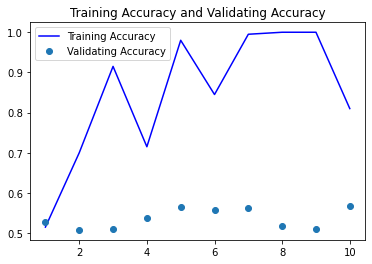

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'o', label = "Validating Accuracy")
plt.title("Training Accuracy and Validating Accuracy")
plt.legend()

plt.show()

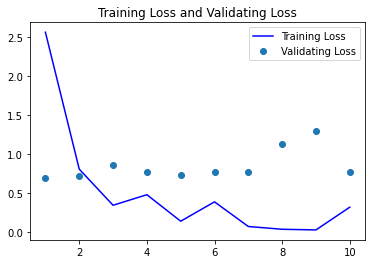

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label = "Training Loss")
plt.plot(epochs, val_loss, 'o', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.legend()

plt.show()

这个模型很快就开始过拟合了，当然在如此少的训练样本的情况下并不让人意外。同样的原因也造成了验证准确率有着很高的方差，不过准确率大约达到了60%。

请注意这个例子中，你运行的结果很可能会不一样：因为我们使用了很少的训练样本，模型的性能严重依赖于你随机选择的200个训练样本。如果你运行的结果与上面相比差了很多，你可以尝试重新随机选择200个样本，当然只是为了练习（真实情况下你不应该挑选你的训练数据）。

我们也可以尝试使用同样的模型但是不载入预训练的词嵌入并且不要冻结嵌入层。这种情况下，我们会学习到一个针对任务特定的嵌入层，这种方法通常在训练数据量较大时更加有效。然而我们只使用了200个训练样本，看看情况如何：

### 在不使用预训练的词嵌入的情况下，训练相同的模型

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding

network = Sequential()
network.add(Embedding(10000, 100, input_length=100))
network.add(Flatten())
network.add(Dense(32, activation='relu'))
network.add(Dense(1, activation='sigmoid'))

network.compile('rmsprop', 'binary_crossentropy', 'accuracy')
network.summary()

history = network.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 1s 68ms/step - loss: 0.6934 - accuracy: 0.5250 - val_loss: 0.6928 - val_accuracy: 0.5142
Epoch 2/10
7/7 [==============================] - 0s 58ms/step - loss: 0.4993 - accuracy: 0.9850 - val_loss: 0.6979 - val_accuracy: 0.5163
Epoch 3/10
7/7 [==============================] - 0s 59ms/step - loss: 0.2748 - accuracy: 0.9850 - val_loss: 0.7292 - val_accuracy: 0.5040
Epoch 4/10
7/7 [==============================] - 0s 55ms/step - loss: 0.1252 - accuracy: 1.0000 - val_loss: 0.7060 - val_accuracy: 0.5261
Epoch 5/10
7/7 [==============================] - 0s 59ms/step - loss: 0.0605 - accuracy: 1.0000 - val_loss: 0.7409 - val_accuracy: 0.5119
Epoch 6/10
7/7 [==============================] - 0s 56ms/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0.7250 - val_accuracy: 0.5229
Epoch 7/10
7/7 [==============================] - 0s 60ms/step - loss: 0.0169 - accuracy: 1.0000 - val_loss: 0.7427 - val_accuracy: 0.5170
Epoch 8/10
7/7 [===========

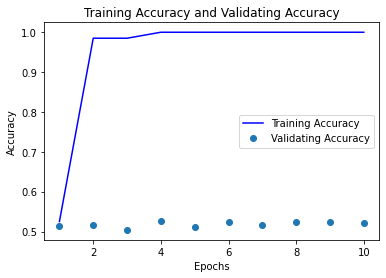

In [23]:
#绘制结果
#1、训练精度和验证精度
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'o', label = "Validating Accuracy")
plt.title("Training Accuracy and Validating Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

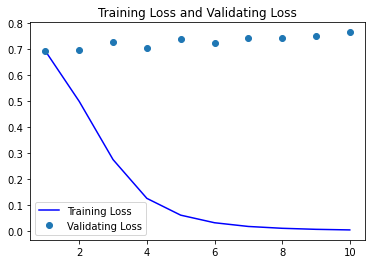

In [24]:
#2、训练损失和验证损失
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label = "Training Loss")
plt.plot(epochs, val_loss, 'o', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.legend()

plt.show()

验证准确率保持在刚过50。因此在这个情况下，预训练词嵌入确实超越了与任务一起学习的嵌入方法。如果你增加训练样本的数量，结果很快将会出现反转，你可以用来作为一个练习。

最后，让我们在测试数据上评测模型。首先我们还是需要标记化测试数据：

In [ ]:
#对测试集数据进行分词
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            with open(os.path.join(dir_name, fname), encoding = 'utf8') as f:
                texts.append(f.read())
            labels.append(0 if label_type == 'neg' else 1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=max_len)
y_test = np.asarray(labels)

In [ ]:
model.load_weights('models/pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

得到了大约54%的测试准确率。使用很少的训练数据是非常困难的！

### 6.1.4 小结

本小节中我们了解了：

- 如何将原始文本转换成神经网络能够处理的数据。
- 在Keras模型中使用嵌入层来学习任务相关的标记化嵌入方法。
- 应用预训练的词嵌入方法来作为小型自然语言处理问题的额外方式。